<a href="https://colab.research.google.com/github/cgrundman/nuclear-magnetic-resonance/blob/master/pattern_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pattern Recognizer

This is the last stage of the Continuous Wave Nuclear Magnatic Resonance Project found at: https://github.com/cgrundman/nuclear-magnetic-resonance. Found in this documentation is merely the information crucial to creating and evaluating the ML model. For more details, please refer to the ``readme`` in the above link.

## Import Libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from google.colab import userdata
import os

## Load Data

In [2]:
# Connect to Kaggle
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [3]:
# Load an
!kaggle datasets download -d christiangrundman/simulated-nmr-data
!unzip -q "simulated-nmr-data.zip"

Dataset URL: https://www.kaggle.com/datasets/christiangrundman/simulated-nmr-data
License(s): MIT
 89% 113M/128M [00:01<00:00, 59.7MB/s]
100% 128M/128M [00:01<00:00, 69.3MB/s]


## Visualize Data

In [4]:
directory = "/content/processed_nmr_data/"

Text(0.5, 1.05, 'Material Samples')

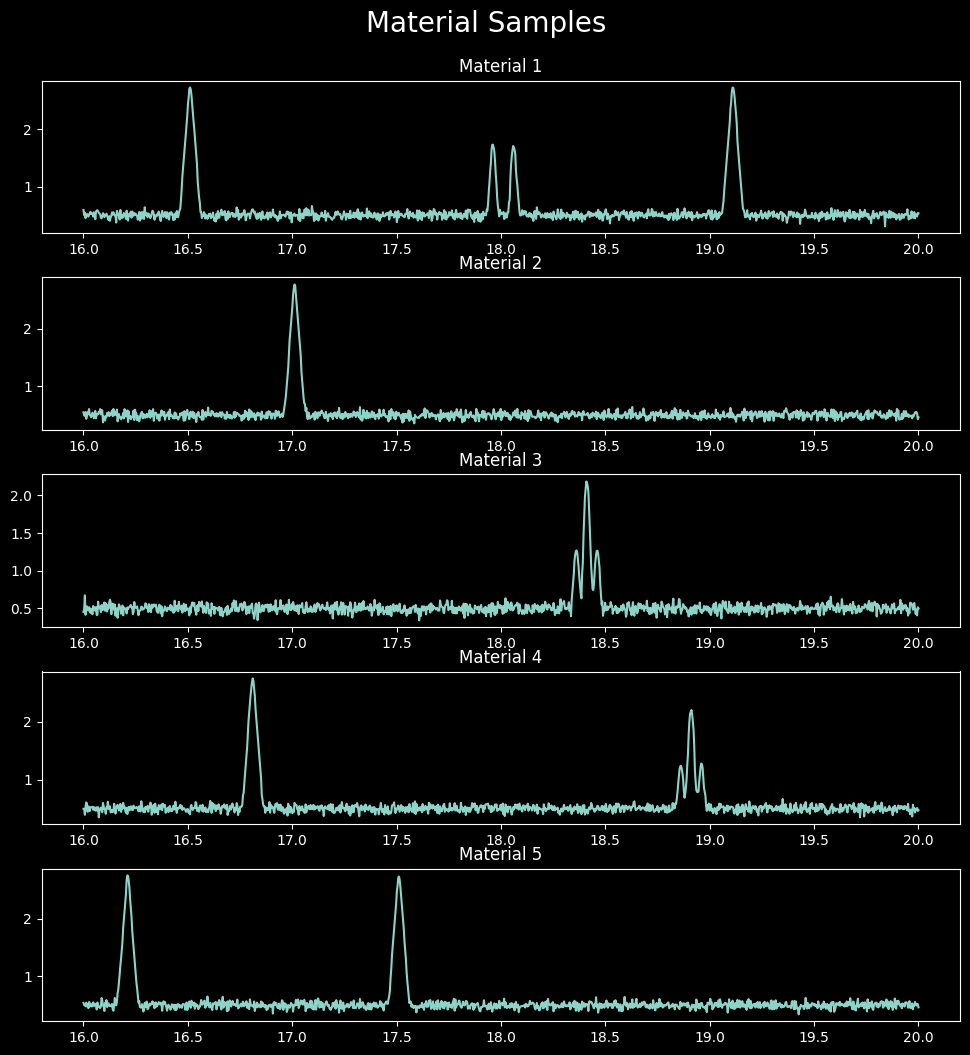

In [14]:
plt.style.use('dark_background')
fig, axs = plt.subplots(5, 1, figsize=(10, 10))
fig.tight_layout()

for i, row in enumerate(axs):
    file = f"0000_Material_{i+1}.txt"
    freq = np.linspace(16, 20, num=1200)
    load_data = np.loadtxt(directory + file)
    row.title.set_text(f"Material {i+1}")
    row.plot(freq, load_data)
plt.suptitle("Material Samples", fontsize=20, y='1.05')

## Create Models

In [ ]:
## TODO Create Model 1

In [ ]:
## TODO Create Model 2

In [ ]:
## TODO Create Model 3

## Show Model's Performance

In [ ]:
# Create Comparison of Models

## Conclusion

In [ ]:
# TODO conclude results of experiment